In [5]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks



Original Distribution:
Class
0    763
1      9
Name: count, dtype: int64


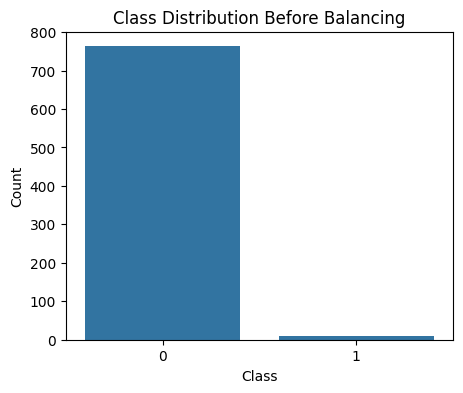


After Balancing:
Class
0    763
1    763
Name: count, dtype: int64


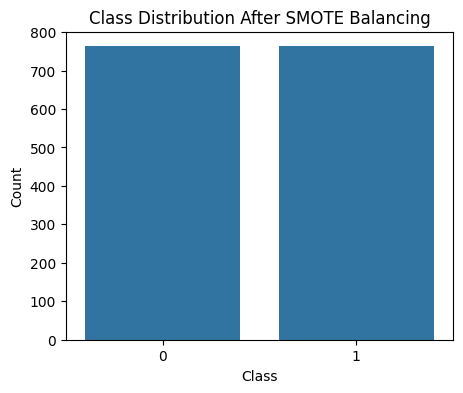

In [6]:
# preprocessing
data_df = pd.read_csv("/content/Creditcard_data.csv")
print("Original Distribution:")
print(data_df['Class'].value_counts())

target_col = "Class"
features = data_df.drop(columns=[target_col])
labels = data_df[target_col]


plt.figure(figsize=(5,4))
sns.countplot(x=labels)
plt.title("Class Distribution Before Balancing")
plt.ylabel("Count")
plt.show()


smote = SMOTE(random_state=42)
bal_features, bal_labels = smote.fit_resample(features, labels)

print("\nAfter Balancing:")
print(pd.Series(bal_labels).value_counts())


plt.figure(figsize=(5,4))
sns.countplot(x=bal_labels)
plt.title("Class Distribution After SMOTE Balancing")
plt.ylabel("Count")
plt.show()



In [7]:
# traning on diffrent models
X_train, X_test, y_train, y_test = train_test_split(
    bal_features, bal_labels, test_size=0.25, stratify=bal_labels,
    shuffle=True, random_state=42
)


sampling_strats = {
    "SMOTE": SMOTE(),
    "ROS": RandomOverSampler(),
    "RUS": RandomUnderSampler(),
    "NEAR": NearMiss(),
    "TOMEK": TomekLinks()
}


classifiers = {
    "LOGR": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "DTREE": DecisionTreeClassifier(),
    "FOREST": RandomForestClassifier(),
    "XGB": XGBClassifier(eval_metric='logloss')
}


accuracies = pd.DataFrame(columns=sampling_strats.keys(), index=classifiers.keys())

for strat_name, strat_inst in sampling_strats.items():
    resamp_X_train, resamp_y_train = strat_inst.fit_resample(X_train, y_train)

    for model_name, model_inst in classifiers.items():
        model_inst.fit(resamp_X_train, resamp_y_train)
        y_pred = model_inst.predict(X_test)
        current_acc = round(accuracy_score(y_test, y_pred)*100, 2)
        accuracies.loc[model_name, strat_name] = current_acc


In [8]:
# accuracy on different models
print("accuracies:")
print(accuracies)


print("\n best sampling techinque per model")
for model_name in accuracies.index:
    best_sampler_for_model = accuracies.loc[model_name].astype(float).idxmax()
    print(f"{model_name} → {best_sampler_for_model}")


print("\n best modeling techninque from these")
for strat_name in accuracies.columns:
    best_model_for_sampler = accuracies[strat_name].astype(float).idxmax()
    print(f"{strat_name} → {best_model_for_sampler}")


overall_max_acc = accuracies.astype(float).max().max()
optimal_model_idx, optimal_sampler_idx = np.where(accuracies.astype(float) == overall_max_acc)

print(f"\n best sample works with best model")
print(f"Model: {accuracies.index[optimal_model_idx[0]]}")
print(f"Sampler: {accuracies.columns[optimal_sampler_idx[0]]}")
print(f"Accuracy = {overall_max_acc}%")

ACCURACY TABLE:
        SMOTE    ROS    RUS   NEAR  TOMEK
LOGR    91.62  91.62  91.62  91.62  91.62
KNN      85.6   85.6   85.6   85.6   85.6
DTREE   97.12  97.64  97.64  97.91  97.38
FOREST  98.95  98.69  98.69  98.69  98.69
XGB     98.43  98.43  98.43  98.43  98.43

 best sampling techinque per model
LOGR → SMOTE
KNN → SMOTE
DTREE → NEAR
FOREST → SMOTE
XGB → SMOTE

 best modeling techninque from these
SMOTE → FOREST
ROS → FOREST
RUS → FOREST
NEAR → FOREST
TOMEK → FOREST

 best sample works with best model
Model: FOREST
Sampler: SMOTE
Accuracy = 98.95%
